# Lab №6. Градиентный бустинг. AdaBoost

## <center>Теоретическая часть<a class="anchor" id="theory"></a><center>

Продолжается тему ансамблей алгоритмов, рассматривая еще один их вид - _градиентный бустинг_. 

Вспоминая тему предыдущей лабораторной работы №5, случайные леса, напомним, что случайный лес - это ансамбль деревьев небольшой глубины, строящихся независимо друг от друга. В независимости построения деревьев кроется и **плюс и минус алгоритма**: с одной стороны, построение деревьев можно **распараллеливать** и, например, организовывать на разных ядрах процессора, с другой стороны, следствием их независимости является тот факт, что для решения сложных задач требуется очень **большое количество деревьев**. В этих случаях случаях (при большой выборке или большом количестве признаков) обучение случайного леса может требовать очень много ресурсов, а если для ограничения их потребления слишком ограничивать глубину деревьев, они могут не уловить все закономерности в данных и иметь большой сдвиг (и, следовательно, ошибку).

**Бустинг** является своеобразным решением этой проблемы: он заключается в **последовательном** построении ансамбля, когда деревья строятся одно за другим, и при этом каждое следующее дерево строится таким образом, чтобы исправлять ошибки уже построенного на данный момент ансамбля. При таком подходе базовые алгоритмы могут быть достаточно простыми, то есть можно использовать неглубокие деревья.

<img src='images/boosting.png'>

## Градиентный бустинг (GBM)<a class='anchor' id='gbm'>
[Видео](https://youtu.be/sDv4f4s2SB8) с подробным объяснением алгоритма

**Продемонстрируем работу бустинга**

In [1]:
from sklearn.datasets import load_diabetes
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score


X, y = load_diabetes(return_X_y=True, as_frame=True)
X

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641
...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018114,0.044485
439,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930


In [8]:
import numpy as np

In [17]:
# Обучаем первое дерево
tree1 = DecisionTreeRegressor(max_depth=3,
                              random_state=2)
tree1.fit(X, y)

prediction1 = tree1.predict(X)
print(f'R2 score {r2_score(y, prediction1)}')

R2 score 0.5006720154703376


In [1]:
# Подсчитываем остатки
residual1 = y - prediction1
y[2], prediction1[2], residual1[2]

NameError: name 'y' is not defined

In [19]:
# Обучаем второе дерево на ошибках предыдущих
tree2 = DecisionTreeRegressor(max_depth=3,
                              random_state=2)

tree2.fit(X, residual1)

prediction2 = tree1.predict(X) + tree2.predict(X)
print(f'R2 score {r2_score(y, prediction2)}')

R2 score 0.5785866108916171


In [20]:
# Подсчитываем остатки
residual2 = y - prediction2
y[2], prediction2[2], residual2[2]

(141.0, 207.5052553799773, -66.50525537997731)

In [22]:
# Обучаем третье дерево на ошибках предыдущих
tree3 = DecisionTreeRegressor(max_depth=3,
                              random_state=2)

tree3.fit(X, residual2)

prediction3 = tree1.predict(X) + tree2.predict(X) + tree3.predict(X)
print(f'R2 score {r2_score(y, prediction3)}')

R2 score 0.6271203539706915


In [23]:
# Подсчитываем остатки
residual3 = y - prediction3
y[2], prediction3[2], residual3[2]

(141.0, 174.76070684814292, -33.76070684814292)

<img src='images/boosting_sum.png'>

<h1 style="color:#008B8B">1. Бустинг в задаче регрессии</h1>

Рассмотрим задачу минимизации квадратичного функционала:

$\large \frac{1}{\ell}
\sum\limits_{i = 1}^{\ell}
    (a(x_i) - y_i)^2
\to
\underset{a}{\text{min}}$

Будем искать итоговый алгоритм в виде суммы *базовых моделей* (weak learners) $b_n(x)$:

$\large a_N(x)
=
\sum\limits_{n = 1}^{N}
    b_n(x)$

где базовые алгоритмы $b_n$ принадлежат некоторому семейству $\mathbb{A}$. Построим первый базовый алгоритм по всем базовым моделям $b \in \mathbb{A}$:

$\large a_1(x) = b_1(x)
:=
\underset{b \in \mathbb{A}}{\text{argmin}}
    \frac{1}{\ell}
    \sum\limits_{i = 1}^{\ell}
        (b(x_i) - y_i)^2$
        
Посчитаем насколько базовая модель ошибается на каждом объете:

$\large s_i^{(1)} = y_i - a_1(x_i)$ - сдвиги


Если прибавить эти остатки к ответам построенного алгоритма, то он не будет допускать ошибок на обучающей выборке. Значит, будет разумно построить второй алгоритм так, чтобы его ответы были как можно ближе к остаткам:

$\large b_2(x)
:=
\underset{b \in \mathbb{A}}{\text{argmin}}
    \frac{1}{\ell}
    \sum\limits_{i = 1}^{\ell}
        (b(x_i) - s_i^{(1)})^2$
        
Если $b_2$ идеальна, значит она равна $s_i^{(1)}$, тогда мы берем копозицию из двух моделей и эта композиция будет всюду выдавать правиьный овет $y_i$:

$\large a_2(x_i) = b_1(x_i) + s_i^{(1)} = b_1(x_i) + y_i - a_1(x_i) = y_i$

Так как зачастую этого недостаточно, тогда мы посчитаем следующие сдвиги:

$\large s_i^{(2)} = y_i - a_2(x_i)$ - сдвиги

Каждый следующий алгоритм тоже будем настраивать на остатки предыдущих:


$\large s_i^{(N)} = 
y_i - \sum\limits_{n = 1}^{N - 1} b_n(x_i)
=
y_i
-
a_{N - 1}(x_i)
\qquad
i = 1, \dots, \ell$

$\large b_N(x)
:=
\underset{b \in \mathbb{A}}{\text{argmin}}
    \frac{1}{\ell}
    \sum\limits_{i = 1}^{\ell}
        (b(x_i) - s_i^{(N)})^2$

<h1 style="color:#008B8B">2. Градиентный бустинг</h1>

Пусть дана некоторая дифференцируемая функция потерь $L(y, z)$. Будем считать, что мы обучили первую модель $b_1(x)$. Как построить следующие модели? Обучение $b_N$ запишем следующую задачу:

$\large \frac{1}{\ell} \sum\limits_{i = 1}^{\ell} L(y_i, a_{N-1}(x_i) + b_N(x_i)) \to \underset{b_N(x)}{\text{min}}$

Где $a_{N-1}(x) = \sum\limits_{n=1}^{N-1} b_n(x)$ композиция из построенной $N-1$ модели.

В этой задаче, мы хотим найти $b_N$ модель такой, что если ее прибавить к построенной композиции, тогда должна получиться более маленькая ошибка. 

Если фукнция потерь удовлетворяет тому, что можно перенести агрумент из одной части в другую $L(y, a+b) = L(y-a, b)$, тогда мы можем дообучать базовую модель на новую целевую переменную:

$\large \frac{1}{\ell} \sum\limits_{i = 1}^{\ell} L(y_i - a_{N-1}(x_i), b_N(x_i)) \to \underset{b_N(x)}{\text{min}}$, тогда мы получаем задачу обучения базовой модели с обновленной целевой переменной, которая равна разности. 

Но, не все функции потерь способны удовлетворять этому требованию. Поэтому, нам необходим другой подход.

### Другой подход

Необходимо понять, как найти $b_N(x)$. Если заместо алгоритма $b_N(x)$ мы хотим понять то, как необходимо изменить прогнозы на отдельных объектах обучающей выборки, чтобы уменьшить ошибку. Предположим, что мы можем к пронозу на каждом объекте обучающей выборки добавить некоторое число $s_i$. Иными словами, нам нужно понять, какие числа $s_1, \ldots, s_{\ell}$ надо выбрать для решения следующей задачи:

$\large \frac{1}{\ell} \sum\limits_{i = 1}^{\ell}
    L(y_i, a_{N - 1}(x_i) + s_i)
\to
\underset{s_1, \dots, s_\ell}{\text{min}}$

Понятно, что можно требовать $s_i = y_i - a_{N - 1}(x_i)$, но такой подход никак не учитывает особенностей функции потерь $L(y, z)$ и требует лишь точного совпадения предсказаний и истинных ответов. Например, имеется не симметричная фукнция потерь, которая по разному штрафует за отклонения, за перепрогноз штраф растет быстрее. Тогда при равной аболютной ошибке штрафы для объектов должны быть разными, следовательно $s_i$ должно на объектах с большим штрафом хотеть больше уменьшить ошибку, так как это внесет большой вклад в ошибку фукнции потреь. Следовательно, мы хотим получить более крупные корректировки для объектво, которые в правой ветке функции потерь, но если использовать текущий вариант, тогда корректировка будет одинаковой для двух объектов, что плохо.

Более разумно потребовать, чтобы сдвиг $s_i$ был противоположен производной функции потерь в точке: $z = a_{N - 1}(x_i)$:

$\large s_i
=
-
\left.
\frac{\partial L(y_i, z)}{\partial z}
\right|_{z = a_{N - 1}(x_i)}$

В этом случае мы сдвинемся в сторону скорейшего убывания функции потерь.
Заметим, что вектор сдвигов $s = (s_1, \dots, s_\ell)$ совпадает

$\large \left(
    -\left.
    \frac{\partial L}{\partial z}
    \right|_{z = a_{N - 1}(x_i)}
\right)_{i = 1}^{\ell}
=
-\nabla_z
\sum\limits_{i = 1}^{\ell}
    L(y_i, z_i)
\big|_{z_i = a_{N - 1}(x_i)}$

При таком выборе сдвигов $s_i$ мы, по сути, сделаем один шаг градиентного спуска, двигаясь в сторону наискорейшего убывания ошибки на обучающей выборке. Отметим, что речь идет о градиентном спуске в $\ell$-мерном пространстве предсказаний алгоритма на объектах обучающей выборки. Поскольку вектор сдвига будет свой на каждой итерации, правильнее обозначать его как $s_i^{(N)}$, но для простоты будем иногда опускать верхний индекс.

Мы придумали чему должны равняться корректировки, но это на данный момент просто числа, которые являются корректировками проноза на $i$-x объектах. А нам необходимо обучать модели. Так как мы знаем, чему дожна быть равна корректировка композиции в $L$ точках, тогда, обучим очередную базовую модель так, чтобы она была как можно ближе к $s_i$. Если базовая модель будет равняться примено сдвигу, тогда мы сдвиним ошибку в меньшую сторону, так как $b_N$ будет двигать в ту сторону, в которую ошибка будешь уменьшаться. Следовательно, будем обучать очередную базовую модель на следующую задачу:

$\large \frac{1}{\ell}\sum\limits_{i = 1}^{\ell} (b_N(x_i) - s_i)^2 \to \underset{b_N(x)}{\text{min}}$

Таким образом, каждый новый алгоритм корректирует ошибки предыдущих, и так продолжается до момента получения приемлемой ошибки на композиции. Вектор коэффициентов $s$ при этом называют _вектором сдвига_.

<img src="images/error.png" width=500px>

Обычно в качестве функции потерь в задачах регрессии принимается *квадратичная функция потерь* ($L_{2}$ loss):

$$L(y, z) = (y - z)^{2},$$

его **производная** по $z$ примет вид 

$$L'(y, z) = 2(z-y)$$

или модуль отклонения ($L_{1}$ loss)

$$L(y, z) = |y - z|,$$

его **производная** по $z$ будет иметь вид 

$$L'(y, z) = \text{sign}(z-y).$$

В случае классификации - логистическая функция потерь (метки -1, +1), где z - оценка принадлежности классу:

$$L(y, z) = log(1 + exp(-yz))$$

ее **производная**:

$$L'(y, z) = - \frac{y\cdot exp(-yz)}{1+exp(-yz)}.$$

Следует помнить, что компоненты $s$, вычисляемые через эти производные, берутся с минусом.

Аналогично алгоритму градиентного спуска, имеет смысл добавлять ответ каждого нового алгоритма не полностью, а с некоторым шагом $\eta \in (0, 1]$, так как базовые алгоритмы обычно достаточно простые (например, деревья малой глубины), и они могут плохо приближать вектор антиградиента, и тогда вместо приближения к минимуму мы будем получать случайное блуждание в пространстве. В градиентном бустинге такой прием называется сокращением шага.

$$a_{N}(x) = a_{N-1}(x) + \eta b_{N}(x).$$

Градиентный бустинг склонен к переобучению при увеличении числа итераций $N$ или глубины входящих в него деревьев. Стоит об этом помнить при построении алгоритма и выбирать оптимальные параметры по отложенной выборке или с помощью кросс-валидации.

### Алгоритм построения модели градиентного бустинга<a class='anchor' id='alg'>

__1.__ Для инициализации выбирается произвольный простой алгоритм $b_{0}(x)$, в его роли можно брать обычные константные алгоритмы: в случае задачи регрессии это может быть

$$b_{0}(x) = 0$$

или среднее значение по всем объектам обучающей выборки 

$$b_{0}(x) = \frac{1}{l}\sum_{i=1}^{l}y_{i};$$

в случае классификации - самый часто встречающийся в выборке класс

$$b_{0}(x) = \underset{y}{\text{argmax}}\sum_{i=1}^{l}[y_{i} = y].$$

__2.__ Для каждой итерации вычисляется вектор сдвига $s$:

$$s = \left ( \left.-\frac{\partial L}{\partial z} \right|_{z = a_{n-1}(x_{1})},...,\left.-\frac{\partial L}{\partial z} \right|_{z = a_{n-1}(x_{l})}\right );$$

находится алгоритм

$$b_{n}(x) = \underset{s}{\text{argmin}}\frac{1}{l}\sum_{i=1}^{l}(b(x_{i})-s_{i})^{2};$$

и добавляется в имеющийся ансамбль с умножением на шаг $\eta$, называемый _скоростью обучения_ (опционно)

$$a_{n}(x) = a_{n-1}(x) + \eta b_{n}(x).$$

__3.__ При достижении критериев остановки компонуется итоговая модель.

### Стохастический градиентный бустинг

Как и в случае с градиентым спуском, есть так называемый стохастический градиентный бустинг, являющийся упрощенной (в плане потребления ресурсов) версией алгоритма. Его суть заключается в обучении каждого нового базового алгоритма на новой итерации не на всей обучающей выборке, а на некоторой ее случайной подвыборке. Практика показывает, что такой алгоритм позволяет получить такую же ошибку или даже уменьшить ее при том же числе итераций, что и в случае использования обычного бустинга.

### Реализация алгоритма градиентного бустинга<a class='anchor' id='implement'>

Реализуем средствами Python алгоритм градиентного бустинга для деревьев решений.

Реализация деревьев решений была дважды продемонстрирована в предыдущих уроках, в этом не будем ее повторять и возьмем готовую реализацию дерева решений для регрессии из библиотеки `sklearn`.

In [33]:
from sklearn import model_selection
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
import numpy as np

Используем один из "игрушечных" датасетов из той же библиотеки.

In [34]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [35]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [36]:
np.zeros(X.shape[0])

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [37]:
def gb_predict(X, trees_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании
    # прибавляются с шагом eta
    
    predictions = np.zeros(X.shape[0])
    for i, x in enumerate(X):
        prediction = 0
        for alg in trees_list:
            prediction += eta * alg.predict([x])[0]
        predictions[i] = prediction
        
    predictions = np.array(
        [sum([eta * alg.predict([x])[0] for alg in trees_list]) for x in X]
    )

    return predictions

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [38]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y - z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z - y)$. Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [39]:
def residual(y, z):
    return - (z - y)

Реализуем функцию обучения градиентного бустинга.

In [40]:
range(10)

range(0, 10)

In [41]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))
        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, residual(y_train, target))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Теперь обучим несколько моделей с разными параметрами и исследуем их поведение.

In [42]:
# Число деревьев в ансамбле
n_trees = 10

# Максимальная глубина деревьев
max_depth = 3

# Шаг
eta = 1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

In [43]:
def evaluate_alg(X_train, X_test, y_train, y_test, trees, eta):
    train_prediction = gb_predict(X_train, trees, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тренировочной выборке: {mean_squared_error(y_train, train_prediction)}')

    test_prediction = gb_predict(X_test, trees, eta)

    print(f'Ошибка алгоритма из {n_trees} деревьев глубиной {max_depth} \
    с шагом {eta} на тестовой выборке: {mean_squared_error(y_test, test_prediction)}')

In [18]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, eta)

Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 1213.0720301179122
Ошибка алгоритма из 10 деревьев глубиной 3     с шагом 1 на тестовой выборке: 4213.552746533081


Построим графики зависимости ошибки на обучающей и тестовой выборках от числа итераций.

In [47]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

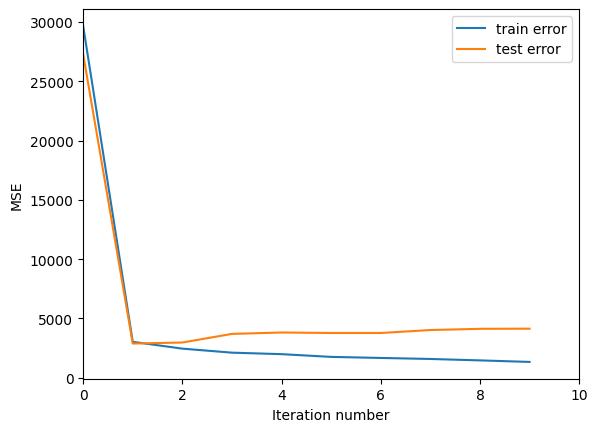

In [20]:
get_error_plot(n_trees, train_errors, test_errors)

Такой результат не является удовлетворительным

Увеличим число деревьев.

In [21]:
%%time
n_trees = 50

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

CPU times: total: 48 s
Wall time: 48.9 s


In [22]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, eta)

Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 1 на тренировочной выборке: 56.430990202161276
Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 1 на тестовой выборке: 4717.318732319312


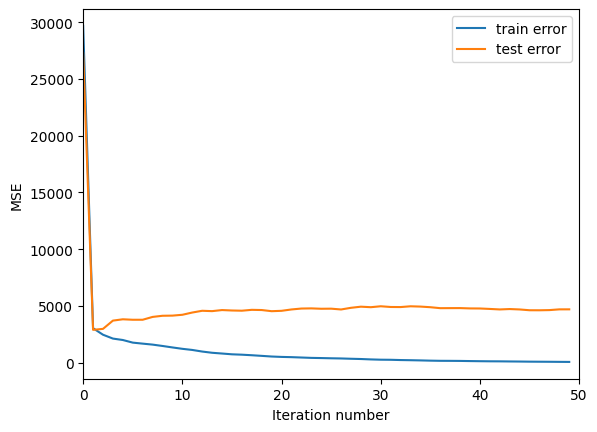

In [23]:
get_error_plot(n_trees, train_errors, test_errors)

Теперь попробуем уменьшить шаг.

In [24]:
%%time
eta = 0.1

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

CPU times: total: 49.6 s
Wall time: 50.3 s


In [25]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, eta)

Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.1 на тренировочной выборке: 1515.8061078424505
Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.1 на тестовой выборке: 2408.1470275623183


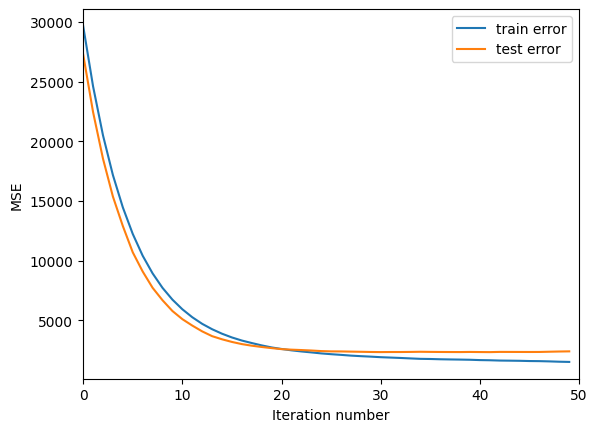

In [26]:
get_error_plot(n_trees, train_errors, test_errors)

Видим, что качество обучения улучшается.

Уменьшим шаг до 0.01.

In [27]:
%%time
eta = 0.01

trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)

CPU times: total: 48.8 s
Wall time: 49.4 s


In [28]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, eta)

Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.01 на тренировочной выборке: 12700.162527225948
Ошибка алгоритма из 50 деревьев глубиной 3     с шагом 0.01 на тестовой выборке: 11166.121790212543


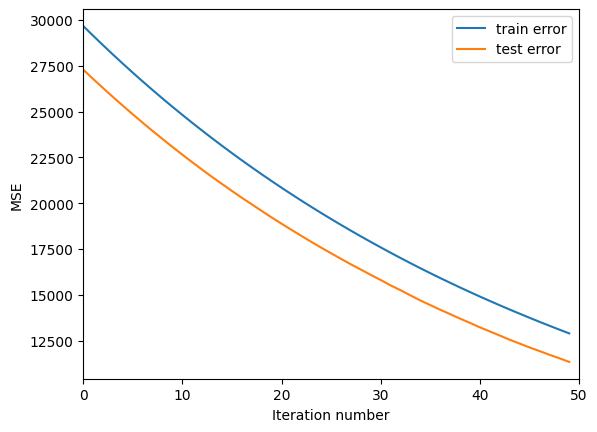

In [29]:
get_error_plot(n_trees, train_errors, test_errors)

При таком размере шага алгоритм сходится, но ему для достижения удовлетворительных показателей требуется большее количество итераций.

Вернемся к шагу 0.1 и попробуем увеличить глубину деревьев

In [44]:
%%time
eta = 0.01
max_depth = 10

trees, train_errors, test_errors = gb_fit(20, max_depth, X_train, X_test, y_train, y_test, eta)

CPU times: total: 14.9 s
Wall time: 17.4 s


In [49]:
evaluate_alg(X_train, X_test, y_train, y_test, trees, eta)

Ошибка алгоритма из 10 деревьев глубиной 10     с шагом 0.01 на тренировочной выборке: 19445.499986349438
Ошибка алгоритма из 10 деревьев глубиной 10     с шагом 0.01 на тестовой выборке: 21270.23884471567


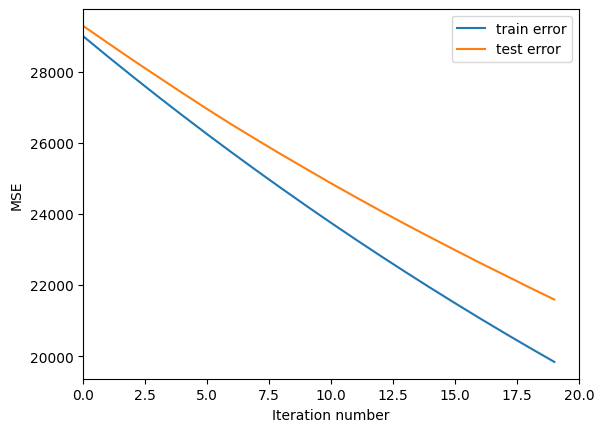

In [50]:
get_error_plot(20, train_errors, test_errors)

Ошибка на обучающей выборке упала, а на тестовой несколько поднялась, то есть в данном случае можем говорить о появлении переобучения.

В целом, тут мы показали, что варьируя параметры обучения градиентного бустинга можно добиваться различного уровня точности модели.

Существуют различные реализации градиентного бустинга, и одна из самых популярных и широко используемых - XGBoost (в Python содержится в библиотеке с аналогичным названием). С этой реализацией можно ознакомиться в дополнительных материалах.

## AdaBoost<a class='anchor' id='ada'>
[Видео](https://www.youtube.com/watch?v=LsK-xG1cLYA) с подробным объяснением алгоритма

Для задачи бинарной классификации он заключается в использовании слабых классификаторов (например, деревьев глубиной 1 - так называемых "пней") в цикле, с придаванием объектам весов. После каждого шага итерации, когда разделяющая плоскость классификатора делит пространство объектов на две части, веса объектов перераспределяются, и веса неправильно классифицированных объектов увеличиваются, чтобы на следующей итерации классификатор акцентировался на этих объектах. Классификатору также присваивается вес в зависимости от его точности. Затем полученные деревья с весами объединяются в один сильный классификатор. В этом и заключается адаптивность алгоритма. Алгоритм AdaBoost также называют алгоритмом усиления классификаторов.

**Продемонстрируем работу AdaBoost**

In [62]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.datasets import load_breast_cancer

In [63]:
X, y = load_breast_cancer(return_X_y=True, as_frame=True)
X.shape, y.shape

((569, 30), (569,))

In [64]:
np.random.seed(6)
index = np.random.randint(0, X.shape[0], 1)
X_test = X.loc[index]
y_test = y.loc[index]

In [65]:
X.columns

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error', 'fractal dimension error',
       'worst radius', 'worst texture', 'worst perimeter', 'worst area',
       'worst smoothness', 'worst compactness', 'worst concavity',
       'worst concave points', 'worst symmetry', 'worst fractal dimension'],
      dtype='object')

In [66]:
X = X.loc[[ 41,  44,  73,  81,  89,  91, 135, 146, 484, 491]]
y = y.loc[[ 41,  44,  73,  81,  89,  91, 135, 146, 484, 491]]
X

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
41,10.95,21.35,71.90,371.1,0.12270,0.12180,0.10440,0.05669,0.1895,0.06870,...,12.84,35.34,87.22,514.0,0.19090,0.26980,0.4023,0.14240,0.2964,0.09606
44,13.17,21.81,85.42,531.5,0.09714,0.10470,0.08259,0.05252,0.1746,0.06177,...,16.23,29.89,105.50,740.7,0.15030,0.39040,0.3728,0.16070,0.3693,0.09618
73,13.80,15.79,90.43,584.1,0.10070,0.12800,0.07789,0.05069,0.1662,0.06566,...,16.57,20.86,110.30,812.4,0.14110,0.35420,0.2779,0.13830,0.2589,0.10300
81,13.34,15.86,86.49,520.0,0.10780,0.15350,0.11690,0.06987,0.1942,0.06902,...,15.53,23.19,96.66,614.9,0.15360,0.47910,0.4858,0.17080,0.3527,0.10160
89,14.64,15.24,95.77,651.9,0.11320,0.13390,0.09966,0.07064,0.2116,0.06346,...,16.34,18.24,109.40,803.6,0.12770,0.30890,0.2604,0.13970,0.3151,0.08473
91,15.37,22.76,100.20,728.2,0.09200,0.10360,0.11220,0.07483,0.1717,0.06097,...,16.43,25.84,107.50,830.9,0.12570,0.19970,0.2846,0.14760,0.2556,0.06828
135,12.77,22.47,81.72,506.3,0.09055,0.05761,0.04711,0.02704,0.1585,0.06065,...,14.49,33.37,92.04,653.6,0.14190,0.15230,0.2177,0.09331,0.2829,0.08067
146,11.80,16.58,78.99,432.0,0.10910,0.17000,0.16590,0.07415,0.2678,0.07371,...,13.74,26.38,91.93,591.7,0.13850,0.40920,0.4504,0.18650,0.5774,0.10300
484,15.73,11.28,102.80,747.2,0.10430,0.12990,0.11910,0.06211,0.1784,0.06259,...,17.01,14.20,112.50,854.3,0.15410,0.29790,0.4004,0.14520,0.2557,0.08181
491,17.85,13.23,114.60,992.1,0.07838,0.06217,0.04445,0.04178,0.1220,0.05243,...,19.82,18.42,127.10,1210.0,0.09862,0.09976,0.1048,0.08341,0.1783,0.05871


In [67]:
y

41     0
44     0
73     0
81     1
89     1
91     0
135    0
146    0
484    1
491    1
Name: target, dtype: int32

__1.__ Инициализация начальных весов объектов из выборки длиной $l$:

$$D_{1}(i) = \frac{1}{l}$$

In [68]:
n_objects = X.shape[0]
w = np.ones(n_objects) / n_objects
w

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [69]:
sum(w)

0.9999999999999999

__2.__ Для каждого из $N$ деревьев в ансамбле:

- находим классификатор $b_{n}$, который минимизирует взвешенную ошибку классификации

$$b_{n} = \underset{b}{\text{argmin}}\;\varepsilon_{j},$$

    где 

$$\varepsilon_{j} = \sum_{i=1}^{l}D_{n}(i)[y_{i}\neq b_{j}(x)]$$

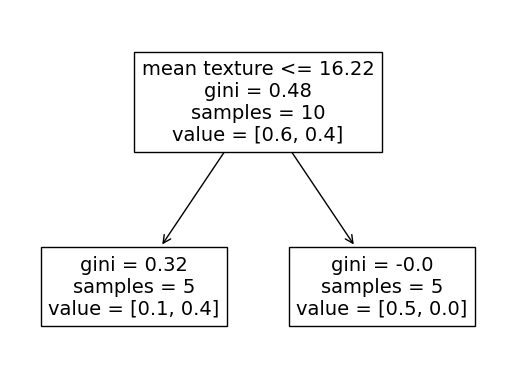

In [70]:
stump1 = DecisionTreeClassifier(max_depth=1, random_state=1)
stump1.fit(X, y, sample_weight=w)

pred = stump1.predict(X)
plot_tree(stump1, feature_names=X.columns, );

In [71]:
pred == y

41      True
44      True
73     False
81      True
89      True
91      True
135     True
146     True
484     True
491     True
Name: target, dtype: bool

In [72]:
error1 = sum(pred != y) / len(y)
error1

0.1

- критерием остановки является значение $\varepsilon_{j} \geq 0.5$. При таком значении ошибки нужно выбрать другой классификатор и продолжить.

- выбираем вес для дерева $\alpha_{n}$ по формуле

$$\alpha_{n} = \frac{1}{2}\text{ln}\frac{1 - \varepsilon_{n}}{\varepsilon_{n}}$$


In [73]:
def amount_of_say(x):
    return 1/2 * np.log((1 - x) / x)

C:\Users\bimas\AppData\Local\Temp\ipykernel_12716\2294868158.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  return 1/2 * np.log((1 - x) / x)
C:\Users\bimas\AppData\Local\Temp\ipykernel_12716\2294868158.py:2: RuntimeWarning: divide by zero encountered in log
  return 1/2 * np.log((1 - x) / x)


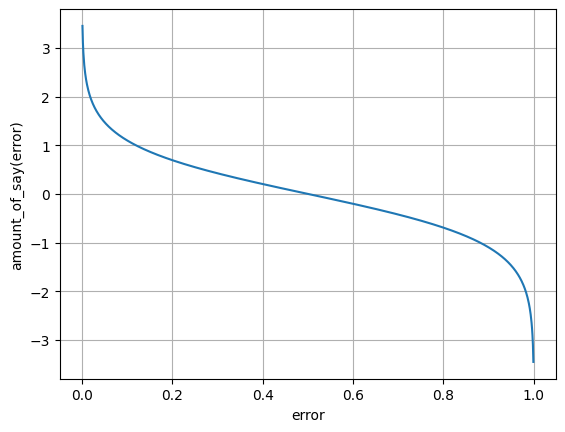

In [74]:
dots = np.linspace(0, 1, 1000)
amount_of_say_value = list(map(amount_of_say, dots))

plt.xlabel('error')
plt.ylabel('amount_of_say(error)')
plt.grid()
plt.plot(dots, amount_of_say_value);

**Получим вес для пня**

In [75]:
alpha1 = 1/2 * np.log((1 - error1) / error1)
alpha1

1.0986122886681098

- обновляем веса при объектах:
$$D_i = D_{i-1}e^{\alpha_i} - \text{изменение веса одного объекта при неверной классификации} $$

In [76]:
def new_sample_weight(x):
    return np.exp(x)

In [77]:
0.1 * np.exp(3.5)

3.3115451958692312

In [82]:
0.1 * np.exp(1.1)

0.30041660239464335

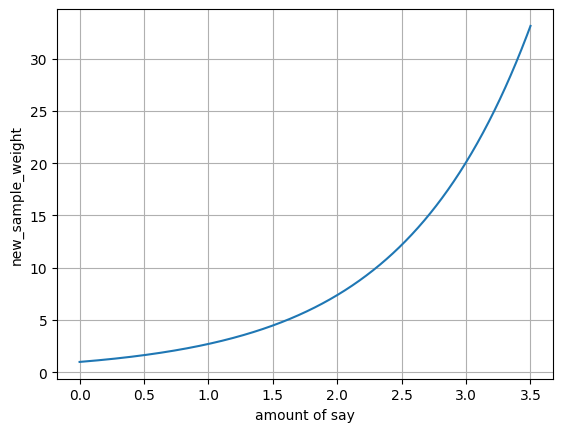

In [83]:
dots = np.linspace(0, 3.5, 1000)
new_sample_weight_value = list(map(new_sample_weight, dots))

plt.xlabel('amount of say')
plt.ylabel('new_sample_weight')
plt.grid()
plt.plot(dots, new_sample_weight_value);

Если пень сделал не очень хорошую классификацию, то вес объекта станет немного больше, если пень сделал хорошую классификацию, то вес объекта станет больше.

**Меняем вес неверное классифицированного объекта**

In [85]:
pred != y

41     False
44     False
73      True
81     False
89     False
91     False
135    False
146    False
484    False
491    False
Name: target, dtype: bool

In [84]:
wrong_mask = pred != y
w[wrong_mask] = w[wrong_mask] * np.exp(alpha1)
w

array([0.1, 0.1, 0.3, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

$$D_i = D_{i-1}e^{-\alpha_i} - \text{изменение веса одного объекта при верной классификации} $$

In [86]:
def new_sample_weight(x):
    return np.exp(-x)

In [87]:
0.1 * np.exp(-3.5)

0.00301973834223185

In [92]:
0.1 * np.exp(-0.1) + 0.01

0.10048374180359596

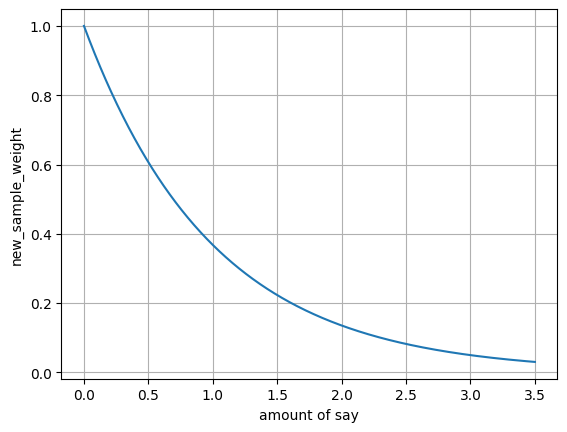

In [93]:
dots = np.linspace(0, 3.5, 1000)
new_sample_weight_value = list(map(new_sample_weight, dots))

plt.xlabel('amount of say')
plt.ylabel('new_sample_weight')
plt.grid()
plt.plot(dots, new_sample_weight_value);

Если пень сделал не очень хорошую классификацию, то вес объекта станет меньше, если пень сделал хорошую классификацию, то вес объекта станет немного меньше.

То есть, те объекты, которые хорошо классифицируются будут иметь меньший вес, чем те, на которых классификатор ошибается.

**Меняем веса верно классифицированных объектов**

In [94]:
w[~wrong_mask] = w[~wrong_mask] * np.exp(-alpha1)
w

array([0.03333333, 0.03333333, 0.3       , 0.03333333, 0.03333333,
       0.03333333, 0.03333333, 0.03333333, 0.03333333, 0.03333333])

In [95]:
sum(w)

0.6

In [96]:
w /= sum(w)

In [97]:
w

array([0.05555556, 0.05555556, 0.5       , 0.05555556, 0.05555556,
       0.05555556, 0.05555556, 0.05555556, 0.05555556, 0.05555556])

In [98]:
sum(w)

1.0000000000000002

**Обучим следующий пень**

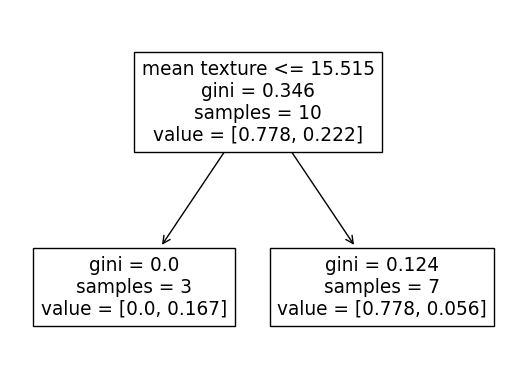

In [99]:
stump2 = DecisionTreeClassifier(max_depth=1, random_state=1)
stump2.fit(X, y, sample_weight=w)

pred = stump2.predict(X)
plot_tree(stump2, feature_names=X.columns);

In [100]:
pred != y

41     False
44     False
73     False
81      True
89     False
91     False
135    False
146    False
484    False
491    False
Name: target, dtype: bool

In [101]:
error2 = sum(pred != y) / len(y)
alpha2 = 1/2 * np.log((1 - error2) / error2)

wrong_mask = pred != y
w[wrong_mask] = w[wrong_mask] * np.exp(alpha2)

w[~wrong_mask] = w[~wrong_mask] * np.exp(-alpha2)
w /= sum(w)
w

array([0.03846154, 0.03846154, 0.34615385, 0.34615385, 0.03846154,
       0.03846154, 0.03846154, 0.03846154, 0.03846154, 0.03846154])

**Обучим следующий пень**

In [102]:
stump3 = DecisionTreeClassifier(max_depth=1, random_state=1)
stump3.fit(X, y, sample_weight=w)

pred = stump3.predict(X)
error3 = sum(pred != y) / len(y)
alpha3 = 1/2 * np.log((1 - error3) / error3)

wrong_mask = pred != y
w[wrong_mask] = w[wrong_mask] * np.exp(alpha3)

w[~wrong_mask] = w[~wrong_mask] * np.exp(-alpha3)
w /= sum(w)
w

array([0.03125, 0.03125, 0.28125, 0.28125, 0.125  , 0.03125, 0.03125,
       0.03125, 0.03125, 0.125  ])

In [103]:
wrong_mask

41     False
44     False
73     False
81     False
89      True
91     False
135    False
146    False
484    False
491     True
Name: target, dtype: bool

**Предскажем классы объектов с помощью трех пней**

In [105]:
display(X_test, y_test)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
227,15.0,15.51,97.45,684.5,0.08371,0.1096,0.06505,0.0378,0.1881,0.05907,...,16.41,19.31,114.2,808.2,0.1136,0.3627,0.3402,0.1379,0.2954,0.08362


227    1
Name: target, dtype: int32

In [106]:
alpha1, alpha2, alpha3

(1.0986122886681098, 1.0986122886681098, 0.6931471805599453)

In [107]:
pred1 = stump1.predict(X_test)
pred2 = stump2.predict(X_test)
pred3 = stump3.predict(X_test)
pred1, pred2, pred3

(array([1]), array([1]), array([0]))

In [107]:
alpha1 + alpha2, alpha3 

(2.1972245773362196, 0.6931471805599453)

In [108]:
pred = 1
y_test

227    1
Name: target, dtype: int32

## Алгоритм AdaBoost<a class='anchor' id='alg_ada'>

__1.__ Инициализация начальных весов объектов из выборки длиной $l$ (равномерно):

$$D_{1}(i) = \frac{1}{l}$$

__2.__ Для каждого из $N$ деревьев в ансамбле:

- находим классификатор $b_{n}$, который минимизирует взвешенную ошибку классификации

$$b_{n} = \underset{b}{\text{argmin}}\;\varepsilon_{j},$$

    где 

$$\varepsilon_{j} = \sum_{i=1}^{l}D_{n}(i)[y_{i}\neq b_{j}(x)]$$
$D_{n}(i)$ - вес объекта, $[y_{i}\neq b_{j}(x)]$ - неправильно классифицированные объекты

- критерием остановки является значение $\varepsilon_{j} \geq 0.5$. При таком значении ошибки нужно выбрать другой классификатор и продолжить.

- выбираем вес для дерева $\alpha_{n}$ по формуле

$$\alpha_{n} = \frac{1}{2}\text{ln}\frac{1 - \varepsilon_{n}}{\varepsilon_{n}}$$

- обновляем веса при объектах:

$$D_{n+1}(i) = \frac{D_{n}(i)e^{-\alpha_{n}y_{i}b_{n}(x_{i})}}{Z_{n}},$$

выражение $y_{i}b_{n}(x_{i})$ в случае $Y = \{-1, 1\}$ будет равняться 1 для правильно классифицированных объектов и -1 для неправильно классифицированных, то есть по сути правильность классификации будет означать, будет $e^{\alpha_{n}}$ стоять в числителе (увеличивается вес неправильно классиф. объектов) или в знаменателе (уменьшается вес правильно классиф. объектов) формулы. В случае $Y = \{0,1\}$ вес будет уменьшаться у правильно классифицированных объектов, а у неправильно классифицированных - оставаться неизменным (до нормализации). $Z_{n}$ здесь - нормализующий параметр, выбираемый так, чтобы $D_{n+1}$ по своей сути являлся распределением вероятностей, то есть

$$\sum_{i=1}^{l}D_{n+1} = 1.$$

### Реализация алгоритма AdaBoost<a class='anchor' id='implement_ada'>

In [120]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer

In [121]:
X, y = load_breast_cancer(return_X_y=True)
X.shape, y.shape

((569, 30), (569,))

Разделим выборку на обучающую и тестовую

In [122]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=32)

Реализуем функцию подсчета ошибки

In [123]:
def get_error(pred, y):
    return sum(pred != y) / len(y)

И сам алгоритм

In [124]:
1 - 1/1000

0.999

In [125]:
def adaboost(X, y, N):

    # Размер выборки
    n_objects = len(X)

    # Запишем количество классов в переменную
    n_classes = len(np.unique((y)))

    # Начальные веса объектов
    w = np.ones(n_objects) / n_objects

    # Деревья с весами будем записывать в список
    models = []

    for n in range(N):
        # Зададим дерево и обучим его
        clf = DecisionTreeClassifier(max_depth=1)
        clf.fit(X, y, sample_weight=w)

        predictions = clf.predict(X)
        error = get_error(predictions, y)
        
        # отбросим дерево, если его ошибка больше 0.5
        # Запишем условие в общем виде (применимо к небинарным классификаторам)
        if error >= 1 - 1/n_classes: 
            continue

        # Обработаем граничные значения ошибок
        if error == 0:
            error += 1e-10
   
        # Вычислим вес для дерева
        alpha = 0.5 * np.log((1 - error) / error)


        # Найдем индексы правильно классифицированных элементов
        wrong_mask = predictions != y

        # Увеличим веса для неправильно классифицированных элементов
        w[wrong_mask] *= np.exp(alpha)
        # Уменьшаем веса для правильно классифицированных элементов
        w[~wrong_mask] *= np.exp(-alpha)

        # Нормализуем веса
        w /= w.sum()

        # Добавим дерево с весом в список
        models.append((alpha, clf))
    
    return models

Обучим алгоритм из 50 деревьев

In [126]:
N = 50

models = adaboost(X_train, y_train, N)

Теперь осуществим предсказание

In [127]:
np.zeros((10, 2))

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [129]:
models

[(1.346562275442767, DecisionTreeClassifier(max_depth=1)),
 (1.0934174367435419, DecisionTreeClassifier(max_depth=1)),
 (0.4393982637232873, DecisionTreeClassifier(max_depth=1)),
 (0.16100126539361112, DecisionTreeClassifier(max_depth=1)),
 (0.4507742250684758, DecisionTreeClassifier(max_depth=1)),
 (1.020212444668692, DecisionTreeClassifier(max_depth=1)),
 (0.1322205542061652, DecisionTreeClassifier(max_depth=1)),
 (0.10365604304876465, DecisionTreeClassifier(max_depth=1)),
 (0.7635999070985642, DecisionTreeClassifier(max_depth=1))]

In [135]:
def predict(X, models):
    
    n_classes = 2
    n_objects = len(X)
    
    # вначале обозначим предсказание нулевым массивом
    y_pred = np.zeros((n_objects, n_classes))
    
    for alpha, clf in models:
        prediction = clf.predict(X)
        # Для каждого предсказания будем прибавлять alpha к
        # элементу с индексом предсказанного класса
        y_pred[range(n_objects), prediction] += alpha
#     print(y_pred)
    
    # выберем индексы с максимальными суммарными весами -
    # получим предсказанные алгоритмом классы
    y_pred = np.argmax(y_pred, axis=1)
    
    return y_pred

In [136]:
print(f'Точность алгоритма на обучающей выборке: {(1 - get_error(predict(X_train, models), y_train)) * 100:.3f}')

Точность алгоритма на обучающей выборке: 96.948


In [137]:
print(f'Точность алгоритма на тестовой выборке: {(1 - get_error(predict(X_test, models), y_test)) * 100:.3f}')

Точность алгоритма на тестовой выборке: 94.406


Построим графики зависимости ошибки от количества базовых алгоритмов в ансамбле.

In [138]:
train_errors = []
test_errors = []

for n in range(1, 31):
    models = adaboost(X_train, y_train, n)
    train_errors.append(get_error(predict(X_train, models), y_train))
    test_errors.append(get_error(predict(X_test, models), y_test))

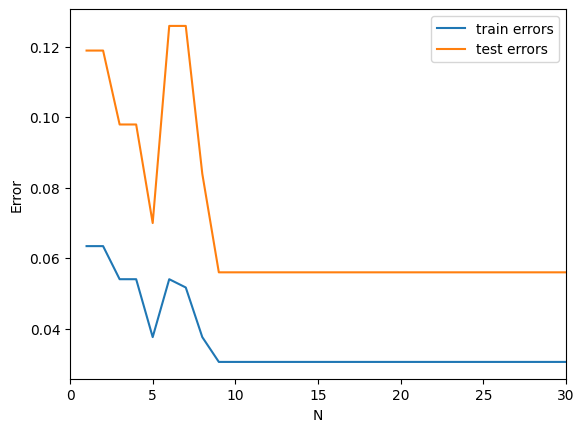

In [139]:
x = list(range(1, 31))

plt.xlim(0, 30)
plt.plot(x, train_errors, label='train errors')
plt.plot(x, test_errors, label='test errors')
plt.xlabel('N')
plt.ylabel('Error')
plt.legend(loc='upper right');

Достоинствами алгоритма AdaBoost можно назвать простоту реализации, хорошую обобщающую способность и небольшую вычислительную сложность. В то же время, есть и недостатки - в первую очередь, склонность к переобучению при наличии в данных шума и выбросов: для наиболее трудноклассифицируемых объектов алгоритм будет определять очень большие веса и в итоге переобучаться на них. В то же время это является и плюсом: таким образом можно идентифицировать выбросы. 

## Домашнее задание<a class='anchor' id='hw'>

1. Для реализованной модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

2. Модифицировать реализованный алгоритм градиентного бустинга, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Сравнить на одном графике кривые изменения ошибки на тестовой выборке в зависимости от числа итераций.

3. Оптимизировать процесс обучения градиентного бустинга, чтобы он занимал меньше времени.

## Дополнительные материалы

1. [Интерактивная демонстрация градиентного бустинга](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)
2. [XGBoost](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture10-ensembles.pdf)
3. [AdaBoost](https://ru.wikipedia.org/wiki/AdaBoost)
4. [XGBoost: A Scalable Tree Boosting System - оригинальная статья](http://scholar.google.ru/scholar_url?url=https://dl.acm.org/ft_gateway.cfm%3Fftid%3D1775849%26id%3D2939785&hl=en&sa=X&scisig=AAGBfm3b8fqJWtjjjejQ5fQwrtg9eQQK-w&nossl=1&oi=scholarr)

## Summary

* На больших и сложных данных градиентный бустинг - один из лучших алгоритмов
* Много настраиваемых параметров 
* Есть очень быстрые реализации 
* Обычно строят на деревьях решений

### Определения
*Бустинг*

**Бустинг** — это техника построения ансамблей, в которой предсказатели построены не независимо, а последовательно.

**Алгоритм построения градиентного бустинга**
1. Инициализация начального алгоритма $b_{0}(x)$

2. Цикл по n = 1,2,3,...:

    * Подсчитывание остатков $s = \left ( \left.-\frac{\partial L}{\partial z} \right|_{z = a_{n-1}(x_{1})},...,\left.-\frac{\partial L}{\partial z} \right|_{z = a_{n-1}(x_{l})}\right );$

    * Обучение нового алгоритма $b_{n}(x) = \underset{s}{\text{argmin}}\frac{1}{l}\sum_{i=1}^{l}(b(x_{i})-s_{i})^{2};$
    
    * Добавление алгоритма в композицию $a_{n}(x) = a_{n-1}(x) + \eta b_{n}(x).$

**Алгоритм построения AdaBoost**
1. Инициализация начальных весов объектов:
$D_{1}(i) = \frac{1}{l}$
2. Цикл по n = 1,2,3,...:

    * находим классификатор $b_{n}$, который минимизирует взвешенную ошибку классификации
$b_{n} = \underset{b}{\text{argmin}}\;\varepsilon_{j},$    где 
$\varepsilon_{j} = \sum_{i=1}^{l}D_{n}(i)[y_{i}\neq b_{j}(x)]$

    * выбираем вес для дерева $\alpha_{n}$ по формуле
    $\alpha_{n} = \frac{1}{2}\text{ln}\frac{1 - \varepsilon_{n}}{\varepsilon_{n}}$
    * обновляем веса при объектах:
$D_{n+1}(i) = \frac{D_{n}(i)e^{-\alpha_{n}y_{i}b_{n}(x_{i})}}{Z_{n}},$
    * критерием останова является значение $\varepsilon_{j} \geq 0.5$. При таком значении ошибки нужно выбрать другой классификатор и продолжить.